# JFK Fligths - Delay Prediction

Diego Rodríguez García - 21/09/2023


## 0. Description

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. 

You have been recently hired as a Data Scientist by the DOT to help them mitigate the consequences of delayed flights. Our assignment is the development of a machine learning model that allows to predict the probability of a flight been delayed. 

As a first exercise, we are implementing a **model to predict whether a flight will have a delay higher than 15 minutes.** The data available contains all relevant information for flights arriving to JFK airport (NYC). This is the data that we will use to build a first pilot version of the model. If this model is proven effective, our model will be extended to incorporate all airports at a national level.  

## 1. Libraries

In [83]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, model_selection, metrics, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import __version__ as sklearn_version

In [84]:
print('The scikit-learn version is {}.'.format(sklearn_version))

The scikit-learn version is 1.2.1.


## 2. Importing data

Before starting with our ML Checklist, the first stage is to import the data for this project (JFKFlights). This dataset is available in the official website for the US Bureau of Transportation Statistics, but we'll directly download it from a public repository in GitHub. The dataset is split in two files because of size limitations from Github. We'll have to import them independently and merge them. 

In [85]:
url1 = 'https://bit.ly/3jAxEwk'
url2 = 'https://bit.ly/3t8qJOf'

In [86]:
df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)

In [87]:
df=pd.concat([df1,df2],axis=0)

## 3. Data understanding and analysis

### `3.1. First impressions`

In [88]:
df.head()

,Unnamed: 0,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,TAXI_OUT,CRS_ARR_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE
0,0,2018-02-01,20363.0,N299PQ,BNA,"Nashville, TN",Tennessee,JFK,"New York, NY",New York,1359,27.0,1719,0.0,140.0,765.0
1,1,2018-02-01,20363.0,N920XJ,RDU,"Raleigh/Durham, NC",North Carolina,JFK,"New York, NY",New York,1354,37.0,1541,0.0,107.0,427.0
2,2,2018-02-01,20363.0,N605LR,BUF,"Buffalo, NY",New York,JFK,"New York, NY",New York,1529,21.0,1709,0.0,100.0,301.0
3,3,2018-02-01,20363.0,N800AY,ORF,"Norfolk, VA",Virginia,JFK,"New York, NY",New York,1704,36.0,1845,0.0,101.0,290.0
4,4,2018-02-01,20363.0,N600LR,BOS,"Boston, MA",Massachusetts,JFK,"New York, NY",New York,1325,20.0,1454,0.0,89.0,187.0


In [89]:
df.shape

(250152, 16)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250152 entries, 0 to 150151
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             250152 non-null  int64  
 1   FL_DATE                250152 non-null  object 
 2   OP_CARRIER_AIRLINE_ID  237644 non-null  float64
 3   TAIL_NUM               235143 non-null  object 
 4   ORIGIN                 250152 non-null  object 
 5   ORIGIN_CITY_NAME       250152 non-null  object 
 6   ORIGIN_STATE_NM        250152 non-null  object 
 7   DEST                   250152 non-null  object 
 8   DEST_CITY_NAME         250152 non-null  object 
 9   DEST_STATE_NM          250152 non-null  object 
 10  CRS_DEP_TIME           250152 non-null  int64  
 11  TAXI_OUT               232641 non-null  float64
 12  CRS_ARR_TIME           250152 non-null  int64  
 13  ARR_DEL15              250152 non-null  float64
 14  CRS_ELAPSED_TIME       250152 non-nu

In [91]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,250152.0,125075.500000,72212.806607,0.0,62537.75,125075.5,187613.25,250151.0
OP_CARRIER_AIRLINE_ID,237644.0,20152.000736,297.881929,19690.0,19790.00,20363.0,20409.00,21171.0
CRS_DEP_TIME,250152.0,1334.611164,529.100385,3.0,915.00,1258.0,1744.00,2359.0
TAXI_OUT,232641.0,18.189820,9.609596,1.0,12.00,16.0,21.00,166.0
CRS_ARR_TIME,250152.0,1419.131404,580.986009,1.0,944.00,1455.0,1914.00,2400.0
ARR_DEL15,250152.0,0.210400,0.407594,0.0,0.00,0.0,0.00,1.0
CRS_ELAPSED_TIME,250152.0,195.647706,97.374339,47.0,109.00,167.0,306.00,595.0
DISTANCE,250152.0,1258.844866,898.116163,94.0,427.00,1028.0,2248.00,4983.0


Here is the available information explaining each variable in the dataset:

* **FL_DATE**: Date of the observation
* **OP_CARRIER_AIRLINE_ID**: IAn identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.
* **TAIL_NUM**: Tail Number, unique identifier for the plane
* **ORIGIN**: origin airport
* **ORIGIN_CITY_NAME**: origin airport
* **ORIGIN_STATE_NM**: origin state (USA)
* **DEST**: destination airport (JFK for all registers)
* **DEST_CITY_NAME**: destination city (NYC for all registers)
* **DEST_STATE_NM**: destination state (NY for all registers)
* **CRS_DEP_TIME**: scheduled departure time
* **TAXI_OUT**: run away time (time between exit from terminal and take-off) 
* **CRS_ARR_TIME**: scheduled arrival time
* **ARR_DEL15**: boolean (1/0) indicating if there has been more than 15 minutes delay
* **CRS_ELAPSED_TIME**: expected flight duration
* **DISTANCE**: distance between airports

We are working on a classification problem, and our target will be the variable **ARR_DEL15**.

In [92]:
df.columns=df.columns.str.lower()
df.columns

Index(['unnamed: 0', 'fl_date', 'op_carrier_airline_id', 'tail_num', 'origin',
       'origin_city_name', 'origin_state_nm', 'dest', 'dest_city_name',
       'dest_state_nm', 'crs_dep_time', 'taxi_out', 'crs_arr_time',
       'arr_del15', 'crs_elapsed_time', 'distance'],
      dtype='object')

In [93]:
target="arr_del15"

### `3.2. Feature variety`

We have observed there are both numerical and categorical features.

In [94]:
df.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
fl_date,250152,730,2018-07-19,394
tail_num,235143,2645,N110AN,761
origin,250152,72,LAX,25345
origin_city_name,250152,70,"Los Angeles, CA",25345
origin_state_nm,250152,32,California,51137
dest,250152,1,JFK,250152
dest_city_name,250152,1,"New York, NY",250152
dest_state_nm,250152,1,New York,250152


Knowing there is always the same destiny (JFK Airport, New York) we are going to remove the columns related to it.

In [95]:
df.drop(columns=["dest","dest_city_name","dest_state_nm"],inplace=True)
df.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
fl_date,250152,730,2018-07-19,394
tail_num,235143,2645,N110AN,761
origin,250152,72,LAX,25345
origin_city_name,250152,70,"Los Angeles, CA",25345
origin_state_nm,250152,32,California,51137


In [96]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
unnamed: 0,250152.0,125075.500000,72212.806607,0.0,62537.75,125075.5,187613.25,250151.0
op_carrier_airline_id,237644.0,20152.000736,297.881929,19690.0,19790.00,20363.0,20409.00,21171.0
crs_dep_time,250152.0,1334.611164,529.100385,3.0,915.00,1258.0,1744.00,2359.0
taxi_out,232641.0,18.189820,9.609596,1.0,12.00,16.0,21.00,166.0
crs_arr_time,250152.0,1419.131404,580.986009,1.0,944.00,1455.0,1914.00,2400.0
arr_del15,250152.0,0.210400,0.407594,0.0,0.00,0.0,0.00,1.0
crs_elapsed_time,250152.0,195.647706,97.374339,47.0,109.00,167.0,306.00,595.0
distance,250152.0,1258.844866,898.116163,94.0,427.00,1028.0,2248.00,4983.0


Let's see how balanced the problem is

<Axes: >

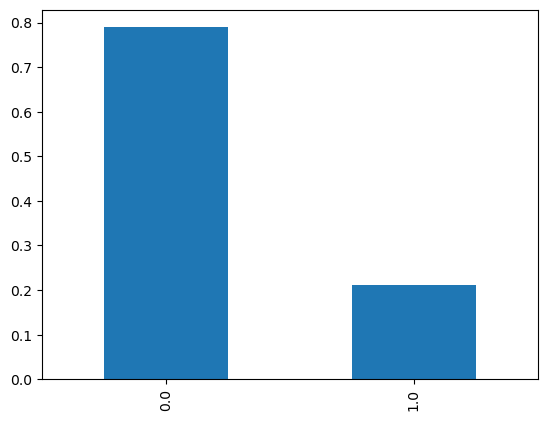

In [97]:
df[target].value_counts(normalize=True).plot(kind="bar")

Even though the delayed flighs are the 20% aproximately, we can consider the problem as a balanced one.

### `3.3. Nulls`

In [98]:
df.isna().sum()

unnamed: 0                   0
fl_date                      0
op_carrier_airline_id    12508
tail_num                 15009
origin                       0
origin_city_name             0
origin_state_nm              0
crs_dep_time                 0
taxi_out                 17511
crs_arr_time                 0
arr_del15                    0
crs_elapsed_time             0
distance                     0
dtype: int64

#### 3.3.1. op_carrier_airline_id

* **OP_CARRIER_AIRLINE_ID**: IAn identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.

In [99]:
df.op_carrier_airline_id.value_counts(dropna=False)

20409.0    78587
19790.0    58894
20363.0    40833
19805.0    30694
NaN        12508
20398.0     8814
19930.0     8591
20452.0     5044
20304.0     3993
21171.0      944
19690.0      695
20397.0      555
Name: op_carrier_airline_id, dtype: int64

We can not manage to study the feature much deeper because it is an id. A solution may be changing the nulls into whatever in order to do later the encoding.

In [100]:
df.op_carrier_airline_id.fillna("NaN",inplace=True)
df.isna().sum()

unnamed: 0                   0
fl_date                      0
op_carrier_airline_id        0
tail_num                 15009
origin                       0
origin_city_name             0
origin_state_nm              0
crs_dep_time                 0
taxi_out                 17511
crs_arr_time                 0
arr_del15                    0
crs_elapsed_time             0
distance                     0
dtype: int64

#### 3.3.2. tail_num

* **TAIL_NUM**: Tail Number, unique identifier for the plane

In [101]:
df.tail_num.value_counts(dropna=False)

NaN       15009
N110AN      761
N113AN      751
N111ZM      748
N115NN      740
          ...  
N197UW        1
N986AN        1
N315RJ        1
N801AW        1
N945DN        1
Name: tail_num, Length: 2646, dtype: int64

Same as before

In [102]:
df.tail_num.fillna("NaN",inplace=True)
df.isna().sum()

unnamed: 0                   0
fl_date                      0
op_carrier_airline_id        0
tail_num                     0
origin                       0
origin_city_name             0
origin_state_nm              0
crs_dep_time                 0
taxi_out                 17511
crs_arr_time                 0
arr_del15                    0
crs_elapsed_time             0
distance                     0
dtype: int64

#### 3.3.3. taxi_out

* **TAXI_OUT**: run away time (time between exit from terminal and take-off) 

In [103]:
df.taxi_out.value_counts(dropna=False)

13.0     18840
12.0     18344
14.0     18119
NaN      17511
15.0     16614
         ...  
146.0        1
161.0        1
159.0        1
140.0        1
156.0        1
Name: taxi_out, Length: 155, dtype: int64

Let's replace them with the value -1.

In [104]:
df.taxi_out.fillna(-1,inplace=True)
df.isna().sum()

unnamed: 0               0
fl_date                  0
op_carrier_airline_id    0
tail_num                 0
origin                   0
origin_city_name         0
origin_state_nm          0
crs_dep_time             0
taxi_out                 0
crs_arr_time             0
arr_del15                0
crs_elapsed_time         0
distance                 0
dtype: int64

### `3.4. More data cleaning`

In [105]:
df['unnamed: 0'].value_counts(dropna=False)

0         1
166758    1
166760    1
166761    1
166762    1
         ..
83388     1
83389     1
83390     1
83391     1
250151    1
Name: unnamed: 0, Length: 250152, dtype: int64

We can consider this feature as an id, so we can remove it aswell

In [106]:
df.drop(columns=["unnamed: 0"],inplace=True)

In [107]:
df['origin_city_name'].value_counts(dropna=False)

Los Angeles, CA      25345
San Francisco, CA    15228
Boston, MA           11201
Orlando, FL           9450
Washington, DC        8197
                     ...  
Daytona Beach, FL      365
Hyannis, MA            171
Eagle, CO              161
Santa Ana, CA           68
Jackson, WY             29
Name: origin_city_name, Length: 70, dtype: int64

In [108]:
df['origin'].value_counts(dropna=False)

LAX    25345
SFO    15228
BOS    11201
MCO     9450
CLT     7769
       ...  
IAH      192
HYA      171
EGE      161
SNA       68
JAC       29
Name: origin, Length: 72, dtype: int64

Both features seem to be quite similar. Thus, as they are not equal, we are maintaining both in our dataset.

 ### `3.5. Range of target values`

#### 3.5.1. Across some features

The evaluation of the target distribution is a fundamental step in supervised learning problems. What's the fraction of 1s in my dataset? For categorical variables, how's the target distributed across features?

In [109]:
def plot_hist_and_boxplot_by_target(df, input_name, target_name, hist_stat = 'count'):
    df_plot = df.copy().dropna()
    fig = plt.figure(figsize=(10, 3))
    fig.suptitle(input_name, fontsize=16)
    ax1 = fig.add_subplot(121)
    sns.histplot(data=df_plot.query(f"{target_name} == 1"), x=input_name, bins = 25, alpha=.5, stat = hist_stat, ax = ax1)
    sns.histplot(data=df_plot.query(f"{target_name} == 0"), x=input_name, bins = 25, alpha=.5, stat = hist_stat, ax = ax1)
    ax2 = fig.add_subplot(122)
    sns.boxplot(data=df_plot, x=target_name, y=input_name, ax=ax2)
    ax2.set_xlabel('Delayed (1) or Not (0)')

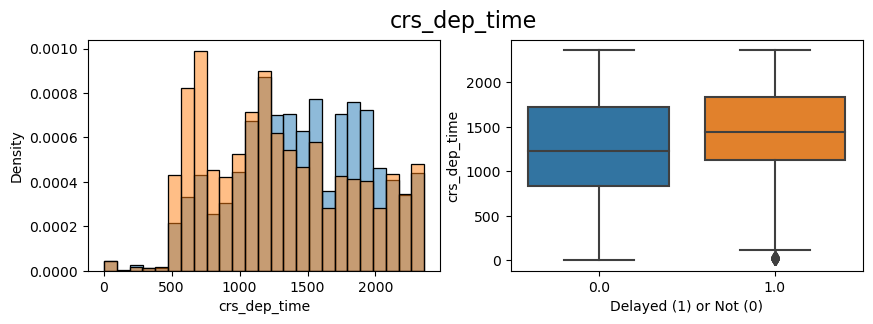

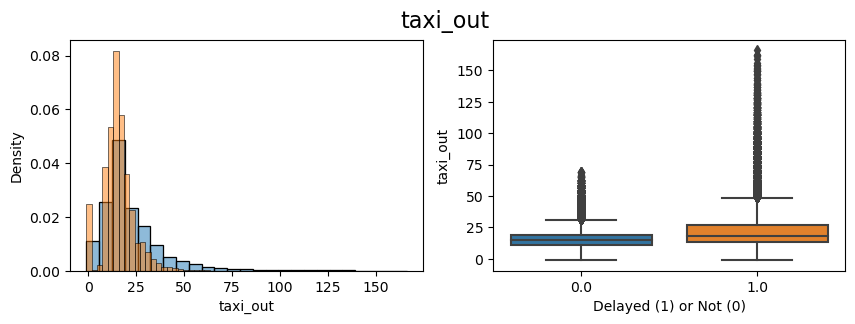

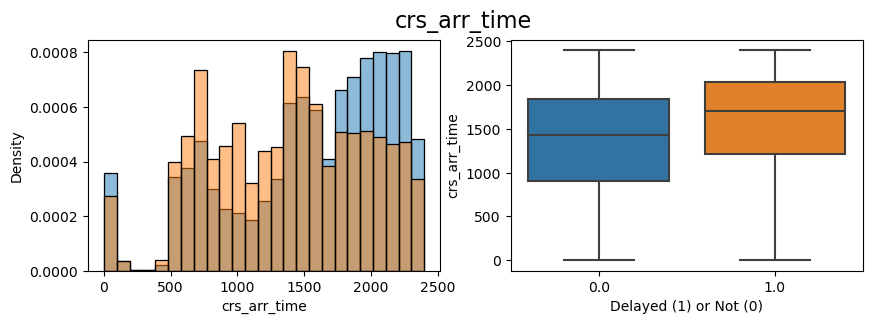

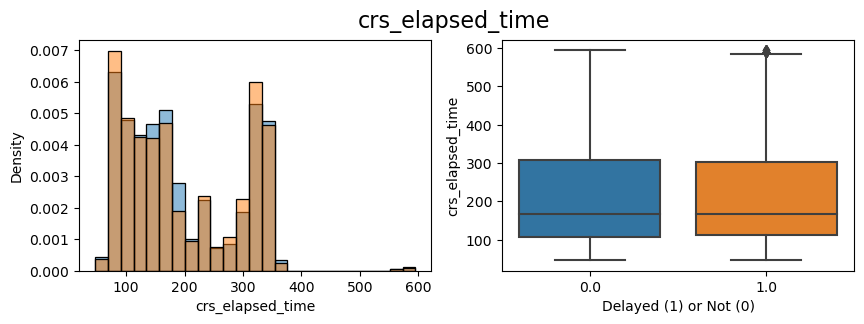

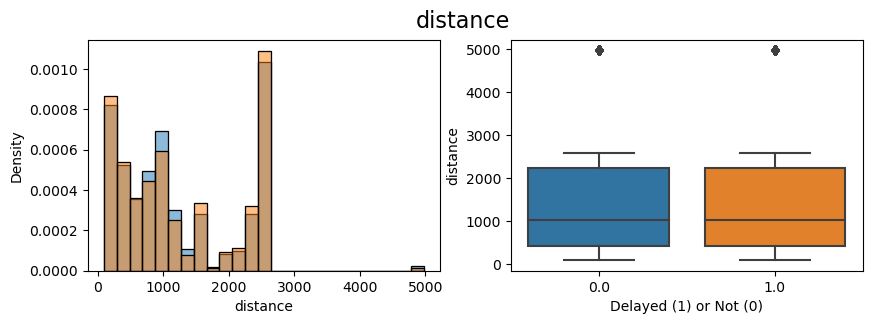

In [110]:
num_cols = list(df.select_dtypes(include = ['float', 'int']).columns)
num_cols = [c for c in num_cols if c != target]

for num_col in num_cols:
    plot_hist_and_boxplot_by_target(df,num_col,target,'density')

The features crs_elapsed_time and distance seem to have a good target distribution. However, in crs_dep_time, taxi_out and crs_arr_time we can see more differences. We considered our model will take this into account.

In [111]:
def plot_barplot_by_target(df, variable, target, normalized = True, stacked = True):
    df_plot = df.groupby([target, variable]).size().reset_index()
    df_plot = df_plot.pivot(index=variable, columns=target)
    df_plot.columns = ["non_delayed", "delayed"]
    df_total = df_plot.sum(axis=1).reset_index(name="conteo_total")
    df_plot = df_plot.merge(df_total, on = variable)
    if normalized:
        df_plot["non_delayed"] /= df_plot["conteo_total"]
        df_plot["delayed"] /= df_plot["conteo_total"]
    df_plot.index = df_plot[variable]
    df_plot.drop(columns = [variable, "conteo_total"], inplace = True)
    df_plot.plot(kind="bar", stacked=stacked, figsize=(10, 3))
    return df_plot.sort_values("delayed", ascending = False,)

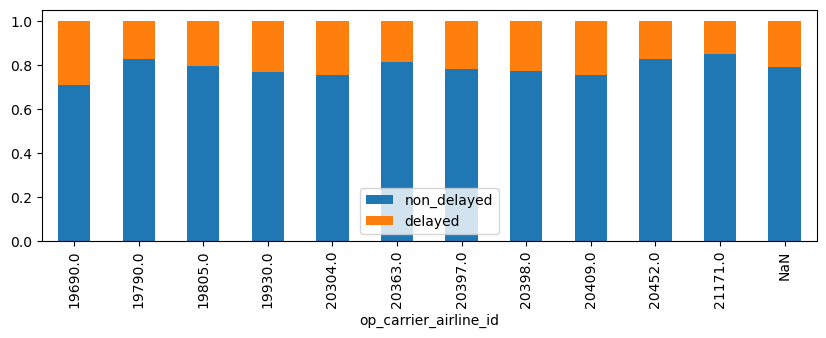

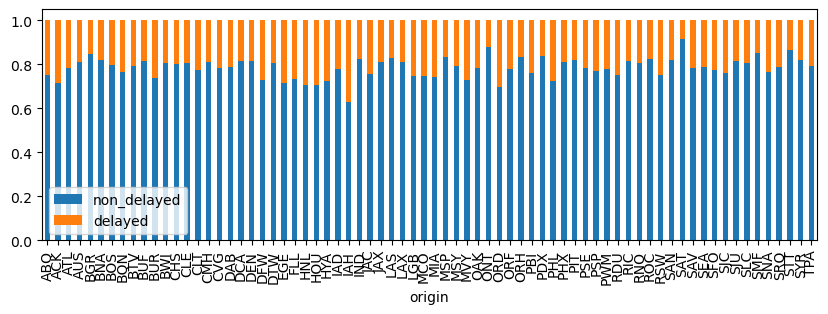

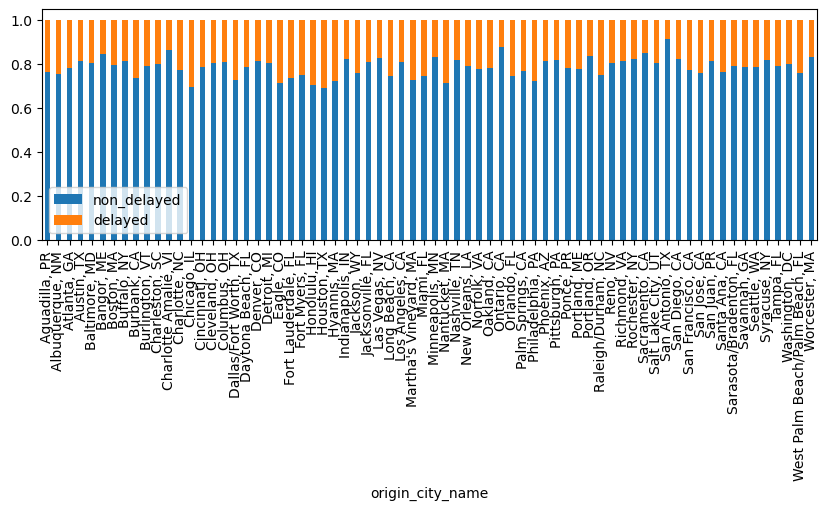

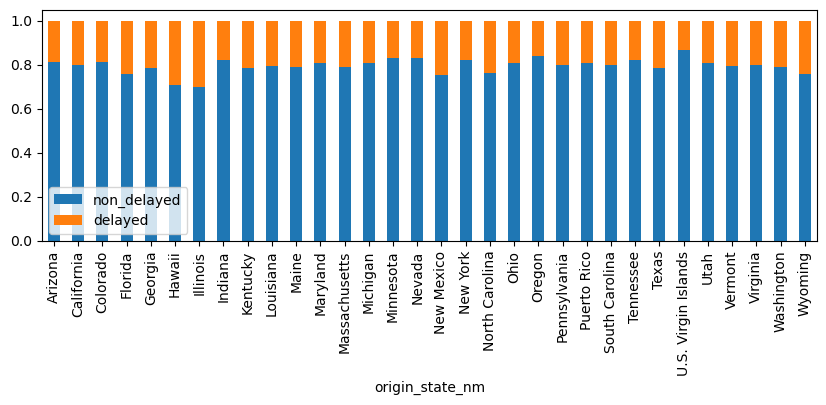

In [112]:
cat_cols = list(df.select_dtypes(exclude = ['float', 'int']).columns)
cat_cols = [c for c in cat_cols if c not in ["fl_date", "tail_num"]]

for cat_col in cat_cols:
    plot_barplot_by_target(df,cat_col,target,True)

There are some cities such as Illinois and Hawaii which delaying percentage is quite lower.

#### 3.5.2. Temporarily

In [113]:
df_daily = df[['fl_date','arr_del15']].groupby(['fl_date']).mean()
df_daily.head()

,arr_del15
fl_date,
2018-01-01,0.315789
2018-01-02,0.320588
2018-01-03,0.211806
2018-01-04,0.833333
2018-01-05,0.877273


Our index is not a date variable. We need to transform it to date format in order for pandas tu interpret it as such (very useful for summaries and plots)

In [114]:
df_daily.index=pd.to_datetime(df_daily.index,format='%Y-%m-%d')
df['fl_date']=pd.to_datetime(df['fl_date'],format='%Y-%m-%d')

We are finally ready to plot distribution of delayed flights across time! 

<Axes: xlabel='fl_date'>

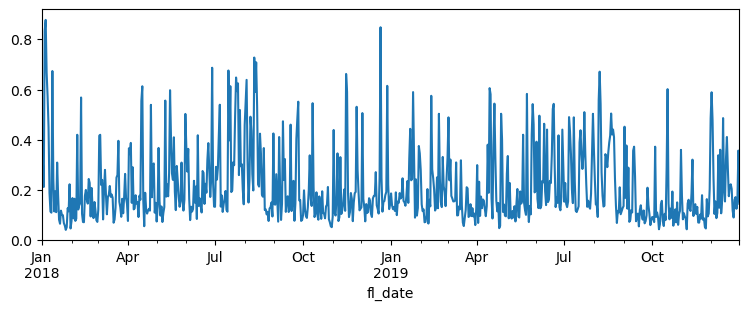

In [115]:
plt.figure(figsize=[9,3])
df_daily['arr_del15'].plot()

The daily plot might not be as clean as we expected. Let's try to plot the weekly mean for the same variable. A weekely mean might allow us to appreciate a certain seasonality of the series. 

In [116]:
df_weekly_mean = df_daily['arr_del15'].resample('W').mean()

<Axes: xlabel='fl_date'>

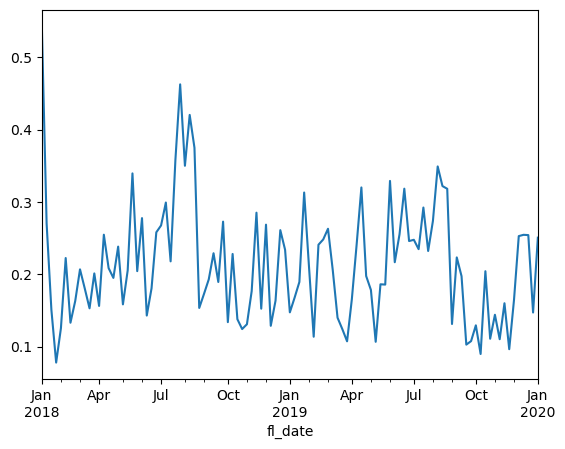

In [117]:
df_weekly_mean.plot()

And let's do the same for a monthly frequency

In [118]:
df_monthly_mean = df_daily['arr_del15'].resample('M').mean()

<Axes: xlabel='fl_date'>

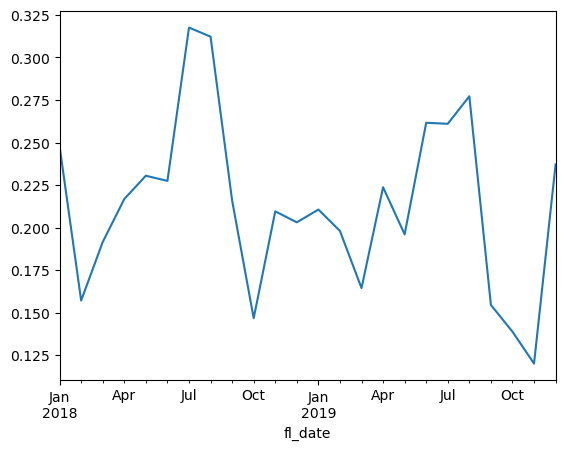

In [119]:
df_monthly_mean.plot()

It seems that the majority of the delays are concentrated during the summer.

Let's see it over the day time.

<Axes: ylabel='Frequency'>

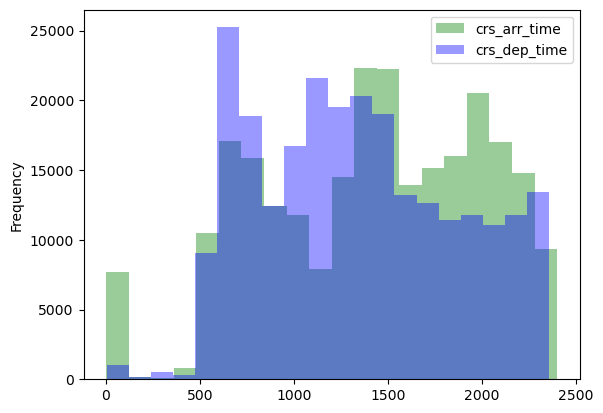

In [120]:
df['crs_arr_time'].plot(kind='hist',bins=20,color='green',alpha=0.4,legend=True)
df['crs_dep_time'].plot(kind='hist',bins=20,color='blue',alpha=0.4,legend=True)

<Axes: ylabel='Frequency'>

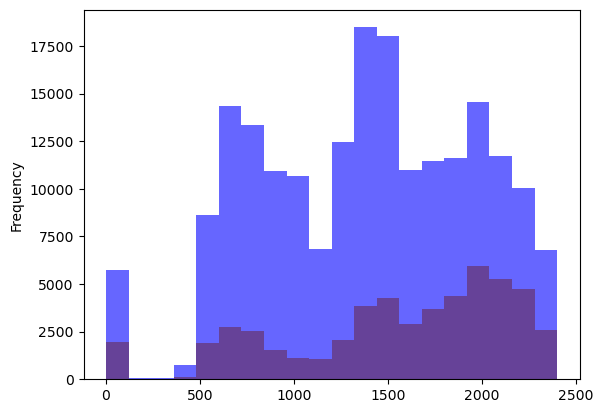

In [121]:
df[df.arr_del15==1]['crs_arr_time'].plot(kind='hist',bins=20,color='orange',alpha=1)
df[df.arr_del15==0]['crs_arr_time'].plot(kind='hist',bins=20,color='blue',alpha=0.6)

There seems to be a higher number of delayed flights at the end of the day, absolutely and relatively.

<Axes: ylabel='Frequency'>

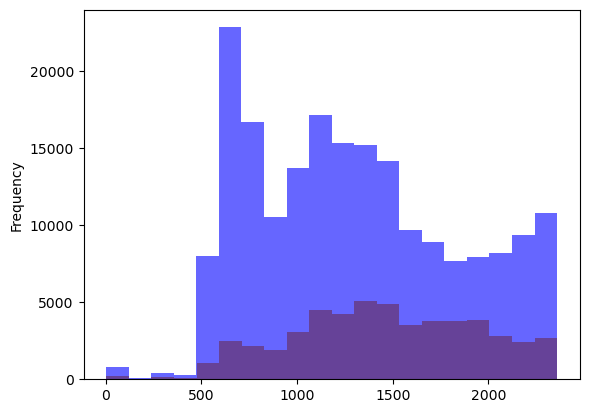

In [122]:
df[df.arr_del15==1]['crs_dep_time'].plot(kind='hist',bins=20,color='orange',alpha=1)
df[df.arr_del15==0]['crs_dep_time'].plot(kind='hist',bins=20,color='blue',alpha=0.6)

Same here.

## 4. Data preparation

### `4.1. Data transformation`

We need to transform the categorical features into numerical. One-hot encodings make sense for variables with a reasonable number of different values.

However, if a categorical variable has too many possible values, we might need to think about transforming its distribution first.

In [123]:
df.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
op_carrier_airline_id,250152.0,12.0,20409.0,78587.0
tail_num,250152,2646,NaN,15009
origin,250152,72,LAX,25345
origin_city_name,250152,70,"Los Angeles, CA",25345
origin_state_nm,250152,32,California,51137


Variables ``op_carrier_airline_id``, ``origin``, ``origin_city_name``, `origin_state_nm` are ideal candidates for one-hot-encoding. They'll result in a total of 184 variables, totally fine for the decision tree and for a regular desktop computer. 

In [124]:
aux=pd.get_dummies(df[['op_carrier_airline_id','origin','origin_city_name','origin_state_nm']])
df=pd.concat([df,aux],axis=1)
df.drop(columns=['op_carrier_airline_id','origin','origin_city_name','origin_state_nm'],inplace=True)
df.shape

(250152, 194)

However, the variable TAIL_NUM has 2647 different values. We'll need to carry out a more thorough analysis for this variable.

In [125]:
df.pivot_table(index='tail_num', values=target, aggfunc=[len, sum, np.mean]).sort_values(by=[('len',target)], ascending = False)

,len,sum,mean
,arr_del15,arr_del15,arr_del15
tail_num,,,
NaN,15009,3109.0,0.207142
N110AN,761,164.0,0.215506
N113AN,751,134.0,0.178429
N111ZM,748,162.0,0.216578
N109NN,740,118.0,0.159459
...,...,...,...
N745VJ,1,0.0,0.000000
N744P,1,0.0,0.000000


Let's try with frequency encoding.

In [126]:
df_tail_num = pd.DataFrame(df['tail_num'].value_counts(dropna = False))
df_tail_num.columns = ['tail_num_count']
df_tail_num['tail_num'] = df_tail_num.index

In [127]:
df=df.merge(df_tail_num,on='tail_num')

In [128]:
df.drop('tail_num',axis=1,inplace=True)

### `4.2. Feature engineering`

There are plenty of new features that we could create for this use case. The feature engineering stage often plays a very important role in helping the model to achieve a better performance. 

We are transforming our FL_DATE variable into a date, and we'll include a few additional time-based variables to our dataframe (might be very helpful for the model): season, year, month, week, weekday.  

In [129]:
df['fl_date'].dtypes

dtype('<M8[ns]')

In [130]:
df['fl_date'] = pd.to_datetime(df['fl_date'])
df['season'] = df['fl_date'].dt.quarter
df['year'] = df['fl_date'].dt.year
df['month'] = df['fl_date'].dt.month
df['week'] = df['fl_date'].dt.week
df['weekday'] = df['fl_date'].dt.weekday

C:\Users\diego\AppData\Local\Temp\ipykernel_10500\3935062405.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['fl_date'].dt.week


In [131]:
df.head()

,fl_date,crs_dep_time,taxi_out,crs_arr_time,arr_del15,crs_elapsed_time,distance,op_carrier_airline_id_19690.0,op_carrier_airline_id_19790.0,op_carrier_airline_id_19805.0,...,origin_state_nm_Vermont,origin_state_nm_Virginia,origin_state_nm_Washington,origin_state_nm_Wyoming,tail_num_count,season,year,month,week,weekday
0,2018-02-01,1359,27.0,1719,0.0,140.0,765.0,0,0,0,...,0,0,0,0,340,1,2018,2,5,3
1,2018-02-03,1021,11.0,1158,0.0,97.0,340.0,0,0,0,...,0,0,0,0,340,1,2018,2,5,5
2,2018-02-06,1325,31.0,1454,0.0,89.0,187.0,0,0,0,...,0,0,0,0,340,1,2018,2,6,1
3,2018-02-08,600,19.0,711,0.0,71.0,94.0,0,0,0,...,0,0,0,0,340,1,2018,2,6,3
4,2018-02-11,1715,11.0,1930,1.0,135.0,636.0,0,0,0,...,0,0,0,0,340,1,2018,2,6,6


Let's create a weekend boolean.

In [132]:
df['weekend']=(df['weekday']>=5).astype(int)

In [133]:
df.drop(columns=['fl_date'],inplace=True)

## 5. Modelling

### `5.1. Dataset split`

This dataset is partitioned by dates. In this type of problems, the best choice is to keep the most recent records as validation set. If the behavior of the target can vary across time, do not forget that our test set needs to resemble as close as possible the scenario that we'd like our model to perform on (i.e. the most recent, the better).

In [134]:
df.pivot_table(index=['year','month'], values='arr_del15', aggfunc=[len, sum, np.mean])

len       sum      mean
           arr_del15 arr_del15 arr_del15
year month                              
2018 1          9244    1968.0  0.212895
     2          9115    1418.0  0.155568
     3          9927    1825.0  0.183842
     4         10393    2184.0  0.210141
     5         10915    2478.0  0.227027
     6         11052    2504.0  0.226565
     7         11201    3463.0  0.309169
     8         11202    3345.0  0.298607
     9         10591    2304.0  0.217543
     10        10952    1628.0  0.148649
     11        10194    2138.0  0.209731
     12        10697    2199.0  0.205572
2019 1         10245    2154.0  0.210249
     2          9381    1817.0  0.193689
     3         11084    1812.0  0.163479
     4         10308    2236.0  0.216919
     5         10797    2122.0  0.196536
     6         10543    2743.0  0.260173
     7         10661    2735.0  0.256543
     8         10782    2912.0  0.270080
     9         10120    1544.0  0.152569
     10        10426    1418.0  0.136006
     11         9937    1205.0  0.121264
     12        10385    2480.0  0.238806

We will use the last 6 months from 2019 as test set, and we will train our model with the partitions from 2018 and the six first months from 2019.  

In [135]:
train=df[(df.year==2018) | (df.month<7)]
test=df[(df.year==2019) & (df.month>6)]
train.shape,test.shape

((187841, 199), (62311, 199))

In [136]:
X_train_=train.drop(target,axis=1)
y_train_=train[[target]]
X_test=test.drop(target,axis=1)
y_test=test[[target]]

Now let's determine train and validation

In [137]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_, y_train_,test_size = 0.30, random_state = 42)
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((131488, 198), (56353, 198), (131488, 1), (56353, 1))

### `5.2. Training`

We are going to instantiate different models, train them and evaluate them.

#### 5.2.1. Decision Tree

##### `5.2.1.1. First training and feature importance`

In [138]:
model521=DecisionTreeClassifier(max_depth=4,random_state=42)

In [139]:
model521.fit(X=X_train,y=y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

[Text(0.5, 0.9, 'taxi_out <= 35.5\ngini = 0.337\nsamples = 100.0%\nvalue = [0.785, 0.215]'),
 Text(0.25, 0.7, 'crs_arr_time <= 1645.5\ngini = 0.312\nsamples = 95.2%\nvalue = [0.807, 0.193]'),
 Text(0.125, 0.5, 'crs_dep_time <= 955.5\ngini = 0.257\nsamples = 59.8%\nvalue = [0.848, 0.152]'),
 Text(0.0625, 0.3, 'crs_dep_time <= 514.0\ngini = 0.183\nsamples = 24.8%\nvalue = [0.898, 0.102]'),
 Text(0.03125, 0.1, 'gini = 0.343\nsamples = 1.0%\nvalue = [0.78, 0.22]'),
 Text(0.09375, 0.1, 'gini = 0.175\nsamples = 23.9%\nvalue = [0.903, 0.097]'),
 Text(0.1875, 0.3, 'taxi_out <= 24.5\ngini = 0.304\nsamples = 35.0%\nvalue = [0.813, 0.187]'),
 Text(0.15625, 0.1, 'gini = 0.285\nsamples = 31.6%\nvalue = [0.827, 0.173]'),
 Text(0.21875, 0.1, 'gini = 0.438\nsamples = 3.4%\nvalue = [0.676, 0.324]'),
 Text(0.375, 0.5, 'taxi_out <= 22.5\ngini = 0.388\nsamples = 35.4%\nvalue = [0.736, 0.264]'),
 Text(0.3125, 0.3, 'op_carrier_airline_id_20409.0 <= 0.5\ngini = 0.358\nsamples = 28.8%\nvalue = [0.766, 0.234]'

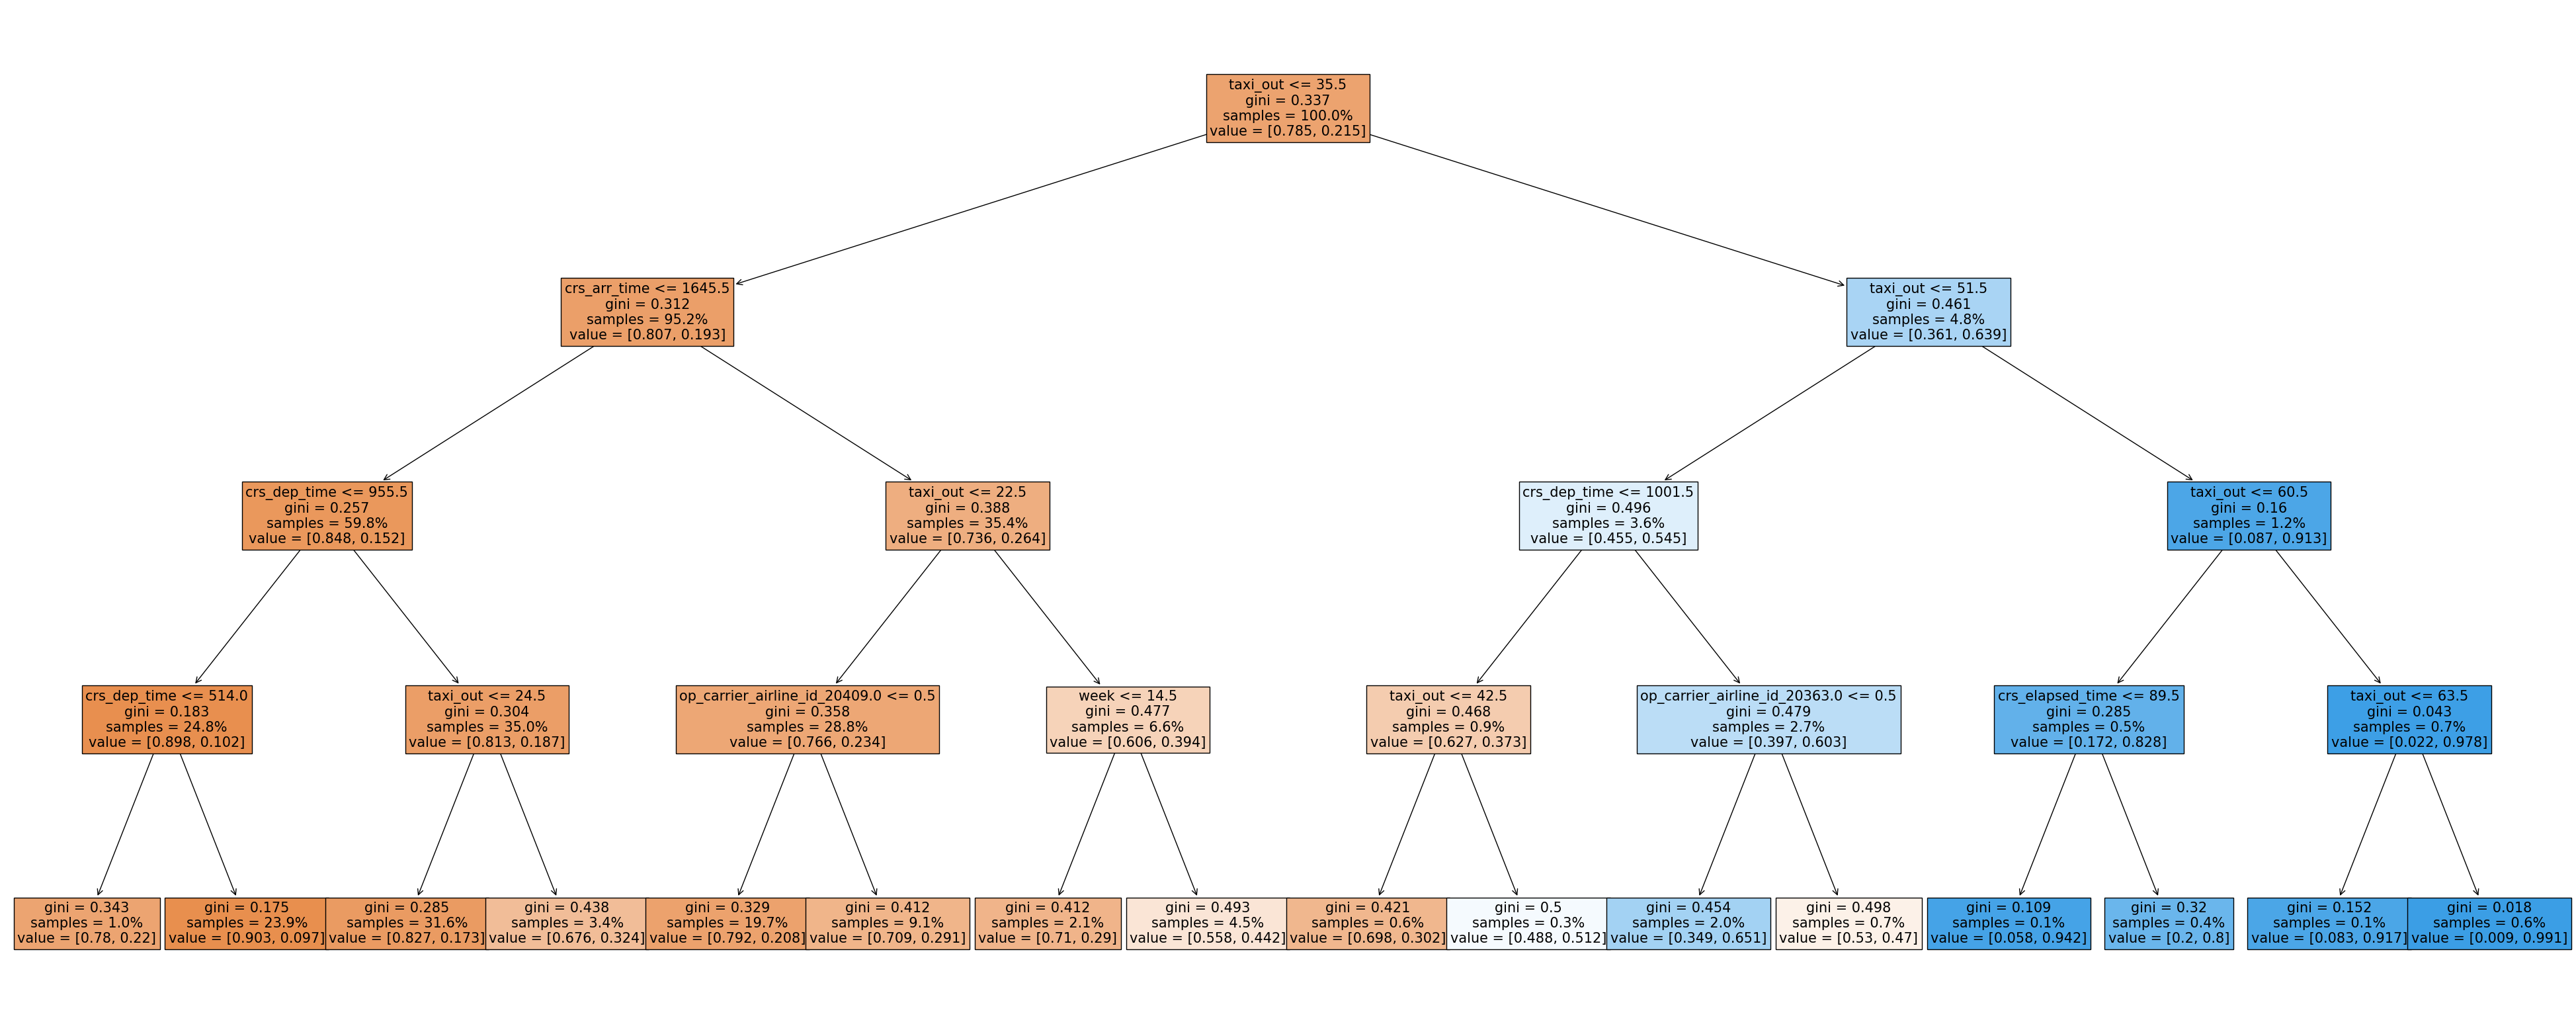

In [140]:
fig, ax = plt.subplots(figsize=(50,20))
tree.plot_tree(model521,ax=ax,fontsize=15,proportion=True,filled=True,feature_names=X_test.columns)

From the visualization of the tree we can see that the most relevant variable is TAXI_OUT. When it takes values hgiher than 35.5, the probability of delay goes from 0.215 to 0.63, and this applies to 4.8% of the cases. If it is higher than 60.5, the probability goes up to 95%.   

Let's take a look at the feature importances of the trained tree

Text(0.5, 0, 'Random Forest Feature Importance')

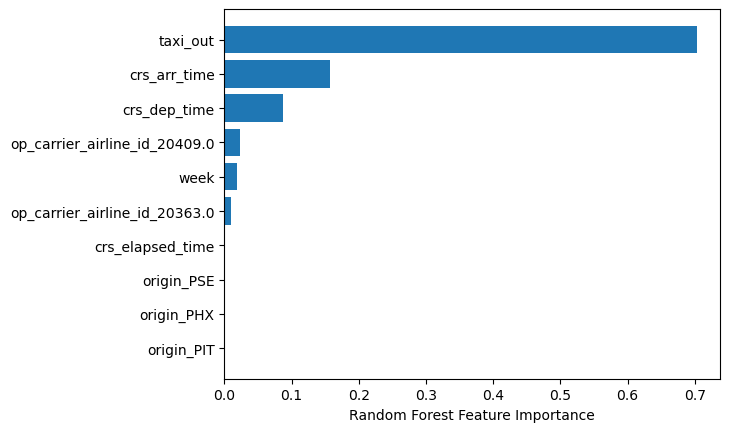

In [141]:
sorted_idx=model521.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], model521.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")

taxi_out is clearly the main feature of the model. We have already seen it's distribution across the target, so it isn't surprising at all.

##### ``5.2.1.2. Hyperparameters optimization``

First of all, the depth.

In [142]:
for i in range(1, 20):
    model521 = DecisionTreeClassifier(max_depth=i, random_state=42)
    model521.fit(X_train, y_train)
    train_accuracy = model521.score(X_train, y_train)
    test_accuracy = model521.score(X_val, y_val)
    print('Tree max_depth: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Tree max_depth: 1. Train: 0.7984835118033585 - Test: 0.7979167036360088
Tree max_depth: 2. Train: 0.7984835118033585 - Test: 0.7979167036360088
Tree max_depth: 3. Train: 0.8007802993429058 - Test: 0.8005962415488084
Tree max_depth: 4. Train: 0.8012822462886348 - Test: 0.8011463453587209
Tree max_depth: 5. Train: 0.8020123509369677 - Test: 0.8016254680318705
Tree max_depth: 6. Train: 0.803921270382088 - Test: 0.8032402888932266
Tree max_depth: 7. Train: 0.8057997688001947 - Test: 0.8036129398612318
Tree max_depth: 8. Train: 0.8094959235823801 - Test: 0.8038791191240928
Tree max_depth: 9. Train: 0.8130551837430031 - Test: 0.8034532323035153
Tree max_depth: 10. Train: 0.8170555487953274 - Test: 0.8046954021968662
Tree max_depth: 11. Train: 0.8223183864687272 - Test: 0.8032935247457988
Tree max_depth: 12. Train: 0.8289273545874909 - Test: 0.8028676379252214
Tree max_depth: 13. Train: 0.8366999269895352 - Test: 0.7999574113179423
Tree max_depth: 14. Train: 0.8460391822827938 - Test: 0.79951

It is very clear how the tree progressively overfits the data as the max_depth parameter increases. We'll have to make sure that we are pruning the tree to minimize the overfitting. 

Let's change now the min_samples_split, which is the hyperparameter that controls the minimum number of samples (observations) required to split an internal node of the tree.

In [143]:
for i in range(1, 20):
    model521 = DecisionTreeClassifier(max_depth=i, random_state=42,min_samples_split=50)
    model521.fit(X_train, y_train)
    train_accuracy = model521.score(X_train, y_train)
    test_accuracy = model521.score(X_val, y_val)
    print('Tree max_depth: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Tree max_depth: 1. Train: 0.7984835118033585 - Test: 0.7979167036360088
Tree max_depth: 2. Train: 0.7984835118033585 - Test: 0.7979167036360088
Tree max_depth: 3. Train: 0.8007802993429058 - Test: 0.8005962415488084
Tree max_depth: 4. Train: 0.8012822462886348 - Test: 0.8011463453587209
Tree max_depth: 5. Train: 0.8020123509369677 - Test: 0.8016254680318705
Tree max_depth: 6. Train: 0.8039060598685812 - Test: 0.8032225436090359
Tree max_depth: 7. Train: 0.8056552689218788 - Test: 0.8037549021347576
Tree max_depth: 8. Train: 0.8090776344609394 - Test: 0.8041098078185722
Tree max_depth: 9. Train: 0.8118079216354344 - Test: 0.8038968644082835
Tree max_depth: 10. Train: 0.8140742881479679 - Test: 0.804642166344294
Tree max_depth: 11. Train: 0.8167969700657094 - Test: 0.8041452983869537
Tree max_depth: 12. Train: 0.8197934412265758 - Test: 0.8037903927031391
Tree max_depth: 13. Train: 0.8228127281577026 - Test: 0.8025837133781698
Tree max_depth: 14. Train: 0.8259993307374057 - Test: 0.80208

A maximum depth of 9 and a minimum samples split of 50 will be a good choice. 

In [144]:
model521=DecisionTreeClassifier(max_depth=9,random_state=42,min_samples_split=50)
model521.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=9, min_samples_split=50, random_state=42)

In [145]:
print(model521.score(X_train,y_train))
print(model521.score(X_val,y_val))
print(model521.score(X_test,y_test))

0.8118079216354344
0.8038968644082835
0.8128420343117587


It seems the model is far from overfitted.

##### ``5.2.1.3. ROC curve ``

In [146]:
y_test_pred = pd.DataFrame({'DelayPrediction' : model521.predict(X_test), 
                            'DelayScore': model521.predict_proba(X_test)[:,1]},
                            index=y_test.index)
results_df_test = y_test.join(y_test_pred, how= 'inner')
results_df_test['Success'] = (results_df_test[target] == results_df_test['DelayPrediction']).astype(int)

print(metrics.roc_auc_score(results_df_test[target],results_df_test['DelayScore']))

0.7017341775831357


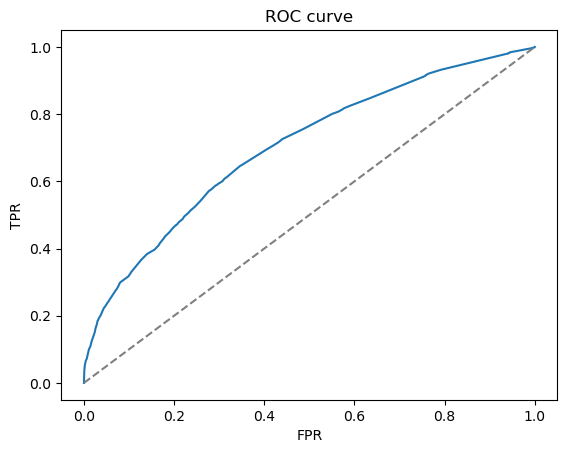

In [147]:
fpr, tpr, _ = metrics.roc_curve(results_df_test[target], results_df_test['DelayScore'])
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

##### ``5.2.1.4. K-fold validation ``

In [148]:
model521k= model_selection.KFold(n_splits=10, shuffle=False)

In [149]:
scores = model_selection.cross_val_score(model521, X_val, y_val, cv=model521k)
scores

array([0.80553584, 0.79808375, 0.79276082, 0.8       , 0.79982254,
       0.80017746, 0.8079858 , 0.80354925, 0.80922804, 0.79698314])

In [150]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.801 (+/- 0.010)


##### `5.2.1.5. Cross Validation`

hay que ver que es dev_df. tiene pinta que el dataset X+y de validacion

In [151]:
scores_list = []
for train_index, test_index in model521k.split(dev_df):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_val.iloc[train_index], X_val.iloc[test_index]
    y_train, y_test = y_val.iloc[train_index], y_val.iloc[test_index]
    dt = DecisionTreeClassifier(max_depth=8, random_state=42)
    dt.fit(X_train, y_train)
    _score = dt.score(X_test, y_test)
    scores_list.append(_score)
    #print(_scores)
scores_list

NameError: name 'dev_df' is not defined

#### 5.2.2. Ensembles

#### 5.2.3. Model comparison

## 6. Model evaluation